# Bitcoin theory of diminishing returns using Data Science

The law of diminishing marginal returns is a theory in economics that states that after some optimal level of capacity is reached, increasing a factor of production will actually result in smaller increases in output.

The aim of this project is to prove that while Bitcoin is know for phenomenal returns, diminishing returns applies as well. We will be proving diminishing returns by calculating the deviation from its fair value (estimated using moving averages and non-linear regression)

We will be using Bitcoin Historical data from kaggle: https://www.kaggle.com/mczielinski/bitcoin-historical-data

###### Steps
1. Calculating the 20 week simple moving average and 21 week exponential moving average. Taking the average as the estimated fair value of bitcoin

2. Calculating the deviation as a percentage of the fair value

3. Repeat by estimating the fair value using logarithmic regression

## Importing Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
btcdata = pd.read_csv('btcdata.csv')
btcdata.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

Data is rather simple with not much preprocessing required
1) Convert UNIX Timestamps to Dates

2) Fill in NAN values with 0  or previous values

3) Convert minute data to weekly data

In [3]:
btcdata["Timestamp"] = pd.to_datetime(btcdata["Timestamp"], unit ='s')
# There are many cells with NaN values as there were no trades at that time
# For Volume and weighted price, these are single events so NAN should be replaced by 0
btcdata["Volume_(BTC)"].fillna(value = 0,inplace = True)
btcdata["Volume_(Currency)"].fillna(value = 0,inplace = True)
btcdata["Weighted_Price"].fillna(value = 0,inplace = True)
#For open high and low close data, this is a continuous data so NAN should be filled with the previous values brought forward
btcdata['Open'].fillna(method='ffill', inplace=True)
btcdata['High'].fillna(method='ffill', inplace=True)
btcdata['Low'].fillna(method='ffill', inplace=True)
btcdata['Close'].fillna(method='ffill', inplace=True)
#Get convert minute data into weekly data
weekly_data = btcdata.groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
weekly_data = weekly_data.drop(["Open","High","Low","Volume_(BTC)","Weighted_Price"], axis =1)
weekly_data.head()

,Timestamp,Close,Volume_(Currency)
0,2012-01-02,4.39,2.0
1,2012-01-09,5.00,0.0
2,2012-01-16,6.30,0.0
3,2012-01-23,7.10,0.0
4,2012-01-30,6.52,0.0


## Bitcoin Bull Market Support Band

In traditional technical analysis, the 20W Simple Moving Average and the 21W Exponential Moving Average is often used to indicate whether an asset is bullish or bearish. We will be using that as estimate of Bitcoins Fairvalue

In [4]:
# Calculates the 20 week simple moving average
sma_20 = weekly_data["Close"].rolling(window = 20).mean()
weekly_data["SMA_20"] = sma_20
# Calculates the 21 week exponential moving average
ema_21 = weekly_data["Close"].ewm(span = 21, adjust = False).mean()
weekly_data["EMA_21"] = ema_21

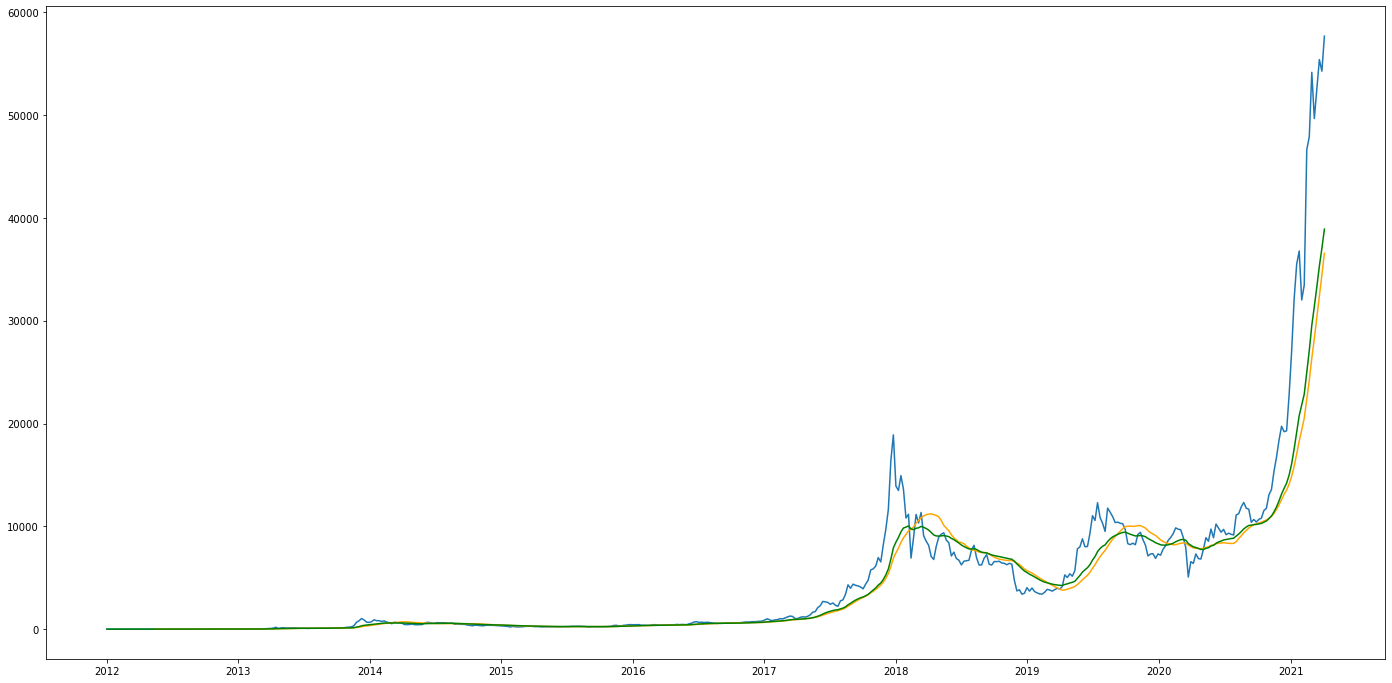

In [5]:
fig = plt.figure(figsize=(24, 12))
#Plots Closing Price of Bitcoin against time with the bull market support band
plt.plot(weekly_data["Timestamp"],weekly_data["Close"])
plt.plot(weekly_data["Timestamp"], weekly_data["SMA_20"], color = 'orange')
plt.plot(weekly_data["Timestamp"], weekly_data["EMA_21"], color = 'green')

## Bitcoin Deviation from the bull market support band

In [6]:
#Find the average between 20WMA, 21WEMA. This will be the estimated "Fair Value" based on the moving averages
weekly_data["Fairvalue_MA"] = weekly_data[["SMA_20","EMA_21"]].mean(axis =1)
#Find the deviation as a percentage of the bull market support band (i.e. 100% = 1)
weekly_data["Deviation_MA"] = weekly_data["Close"]/weekly_data["Fairvalue_MA"] *100
weekly_data.head()

,Timestamp,Close,Volume_(Currency),SMA_20,EMA_21,Fairvalue_MA,Deviation_MA
0,2012-01-02,4.39,2.0,NaN,4.390000,4.390000,100.000000
1,2012-01-09,5.00,0.0,NaN,4.445455,4.445455,112.474438
2,2012-01-16,6.30,0.0,NaN,4.614050,4.614050,136.539495
3,2012-01-23,7.10,0.0,NaN,4.840045,4.840045,146.692849
4,2012-01-30,6.52,0.0,NaN,4.992768,4.992768,130.588877


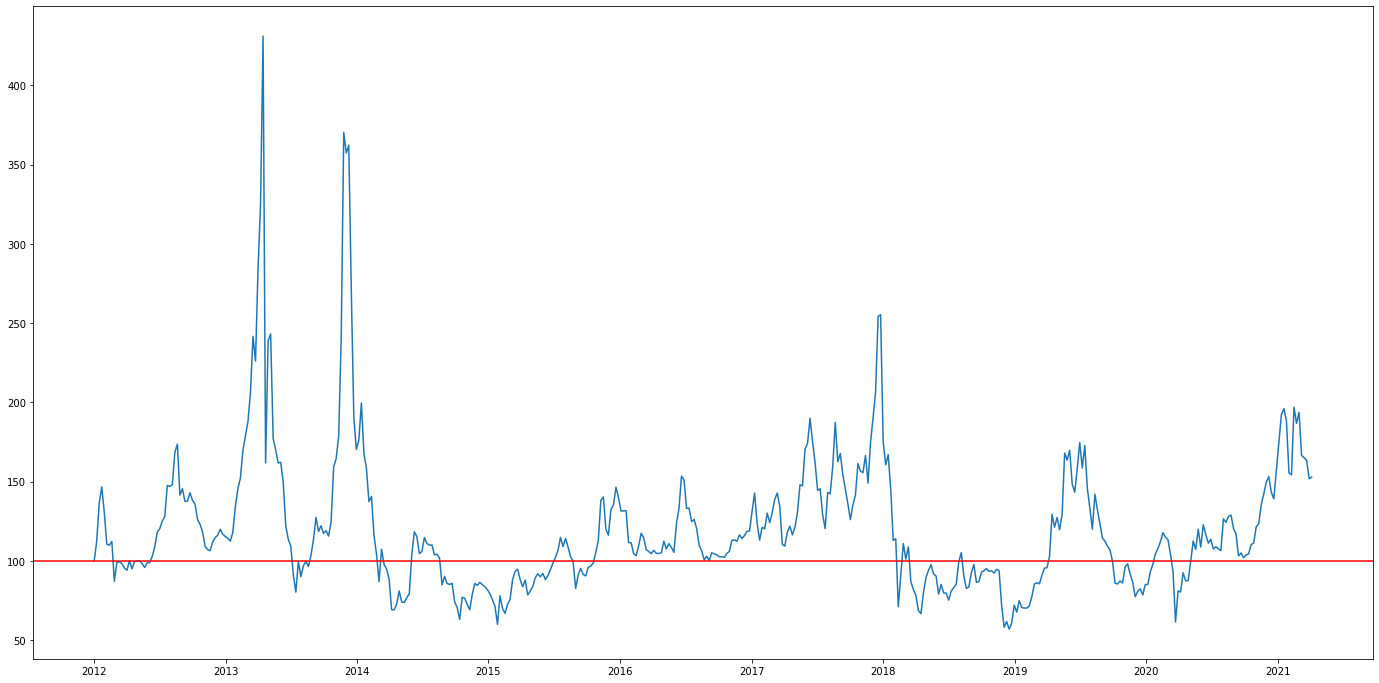

In [7]:
fig = plt.figure(figsize=(24, 12))
# Plots the deviation with respect to time
plt.plot(weekly_data["Timestamp"],weekly_data["Deviation_MA"])
# Red line represents the "Fair Value" at any given time
plt.axhline(y=100, color='r', linestyle='-')

The blue line represents the deviation from the fair value, calculated as a percentage of the fair value (price/fairvalue). The red line represents the fairvalue at 100%

## Bitcoin Logarithmic Regression

[  4.44766752 -18.49391208  82.78602658]


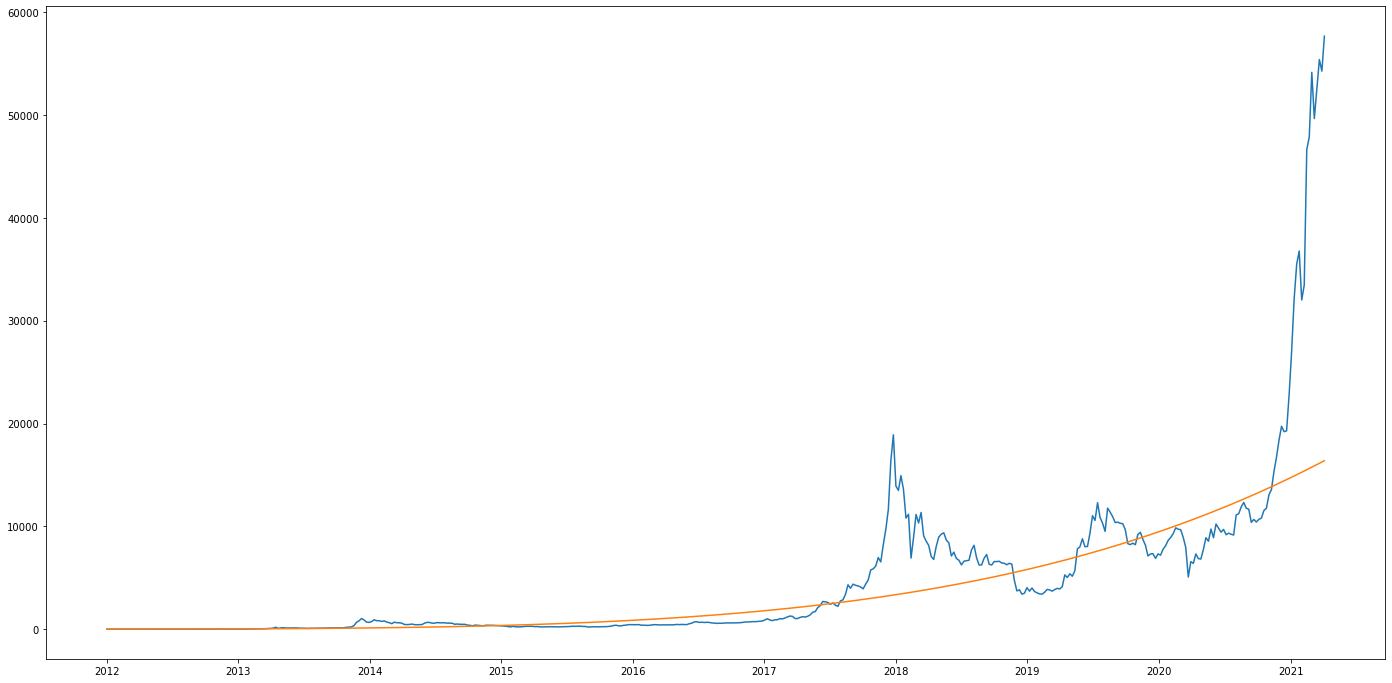

In [8]:
from scipy.optimize import curve_fit 

fig = plt.figure(figsize=(24, 12))
# Regression Fitting function
def log_reg(x,p1,p2,p3):
    #The formula for a logarithmic equation
    return p1*np.log(x+p3)+p2

xdata = np.array([x+1 for x in range(len(weekly_data))])
ydata = np.log(weekly_data["Close"])

#Fit the curve to the data
#Calculates the parameters to input in to log_reg function
p,cov = curve_fit(log_reg,xdata,ydata)
print(p)
fitted_data = log_reg(xdata,p[0],p[1],p[2])

#Plots Bitcoins data
plt.plot(weekly_data["Timestamp"],weekly_data["Close"])
#Plots fitted line
plt.plot(weekly_data["Timestamp"],np.exp(fitted_data))


## Bitcoin Deviation from Logarithmic "Fair Value"

In [9]:
# Convert the fitted data array into a dataframe and append it to weekly data
weekly_data["Fairvalue_log"] = pd.DataFrame(np.exp(fitted_data))
weekly_data["Deviation_log"] = weekly_data["Close"]/weekly_data["Fairvalue_log"] *100
weekly_data.head()

,Timestamp,Close,Volume_(Currency),SMA_20,EMA_21,Fairvalue_MA,Deviation_MA,Fairvalue_log,Deviation_log
0,2012-01-02,4.39,2.0,NaN,4.390000,4.390000,100.000000,3.325247,132.020281
1,2012-01-09,5.00,0.0,NaN,4.445455,4.445455,112.474438,3.505430,142.635851
2,2012-01-16,6.30,0.0,NaN,4.614050,4.614050,136.539495,3.693091,170.588802
3,2012-01-23,7.10,0.0,NaN,4.840045,4.840045,146.692849,3.888448,182.592143
4,2012-01-30,6.52,0.0,NaN,4.992768,4.992768,130.588877,4.091721,159.346150


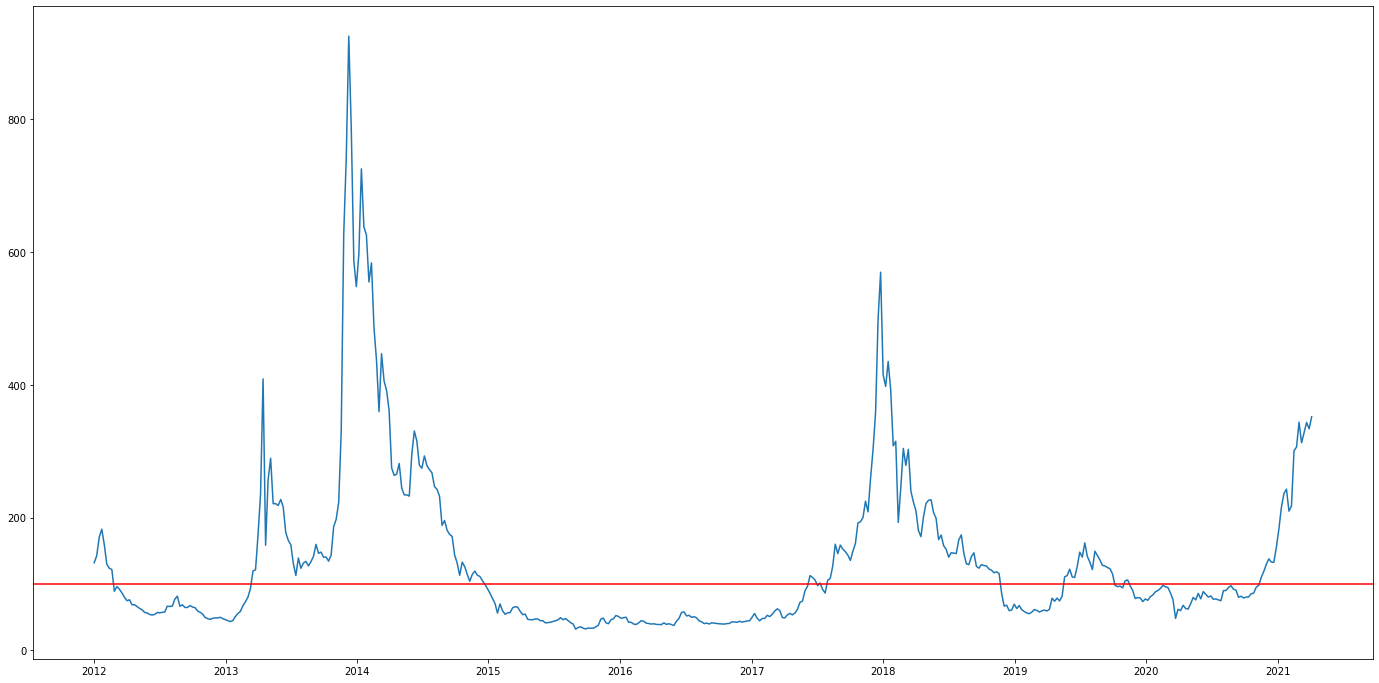

In [10]:
fig = plt.figure(figsize=(24, 12))
plt.plot(weekly_data["Timestamp"],weekly_data["Deviation_log"])
# Plot horizontal line at 100 to represent fair value
plt.axhline(y=100, color='r', linestyle='-')

The blue line represents the deviation from the fair value, calculated as a percentage of the fair value (price/fairvalue). The red line represents the fairvalue at 100%

# Conclusion

In this analysis, its clear that throughout the years, while volatility still exist in Bitcoin, the volatility and deviation from its fair value has been gradually decreasing. This is true in both our estimates of Bitcoins fairvalue.

This proves the law of diminishing returns even in a trending asset class like cryptocurrency.